<a href="https://colab.research.google.com/github/nikerdon/Sign_recognition/blob/main/ML_course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинное обучние (проект)

## Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import shutil

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

100%|██████████| 612M/612M [00:11<00:00, 55.9MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


## Загрузка данных и обрез изображений

In [3]:
# знаки, которые будем смотреть
labels = {
    33:'Только поворот направо',
    34:'Только поворот налево',
    35:'Только вперед',
    36:'Вперед или направо',
    37:'Вперед или налево',
    38:'Держитесь правее',
    39:'Держитесь левее'
}

In [4]:
from PIL import Image
from tqdm import tqdm

def load_csv_data(csv_path, labels):
    """
    Загружает CSV файл, удаляя не нужные нам знаки (то бишь которых нет в labels)

    Параметры:
    csv_path (str) - путь к файлу
    labels (dict) - словарь признаков, на которых делаем : {номер:название}

    Возвращает:
    Дата Фрейм из csv файла
    """
    df = pd.read_csv(csv_path)

    df['label']=df['ClassId'].map(labels)
    df = df[df.label.notna()]
    df.reset_index(drop=True, inplace=True)

    return df

def crop_traffic_signs(df, images_dir, save_dir):
    """
    Функция для обрезки изображений дорожных знаков по координатам

    Параметры:
    df (pd.DataFrame) - DataFrame с колонками ['Path', 'Roi.X1(Y1|X2|Y2)', 'ClassId']
    images_dir (str) - Путь к директории с исходными изображениями
    save_dir (str) - Путь к директории для сохранения обрезанных изображений

    Возвращает:
    None
    """

    # Удаляем директорию, если она существует, и создаем её заново
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)
    os.makedirs(save_dir, exist_ok=True)

    # Погнали обрезать
    for idx, row in df.iterrows():
        img_path = os.path.join(images_dir, row['Path'])
        x1, y1, x2, y2 = int(row['Roi.X1']), int(row['Roi.Y1']), int(row['Roi.X2']), int(row['Roi.Y2'])
        class_id = row['ClassId']

        # Загружаем изображение
        img = cv2.imread(img_path)

        if img is None:
            print(f"Не удалось загрузить изображение: {img_path}")
            continue

        # Проверка границ обрезки (иначе вылетает, так где то косяк походу)
        height, width = img.shape[:2]
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(width, x2), min(height, y2)

        # Обрезаем изображение
        cropped_img = img[y1:y2+1, x1:x2+1]

        # Создаем директорию для класса
        class_dir = os.path.join(save_dir, str(class_id))
        os.makedirs(class_dir, exist_ok=True)

        # Сохраняем обрезанное изображение
        save_path = os.path.join(class_dir, os.path.basename(img_path))
        cv2.imwrite(save_path, cropped_img)

    print("Обрезка завершена")


data_train = load_csv_data(path + '/Train.csv', labels)
data_test = load_csv_data(path + '/Test.csv', labels)

# создаем файлы с обрезанными данными (лучше всегда создавать)
crop_traffic_signs(data_train, path, path + '/Train_crop')
crop_traffic_signs(data_test, path, path + '/Test_crop')

Обрезка завершена
Обрезка завершена


In [5]:
data_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,label
0,26,26,5,5,20,21,33,Train/33/00033_00000_00000.png,Только поворот направо
1,27,28,5,6,22,23,33,Train/33/00033_00000_00001.png,Только поворот направо
2,27,27,5,5,22,21,33,Train/33/00033_00000_00002.png,Только поворот направо
3,28,27,6,5,23,22,33,Train/33/00033_00000_00003.png,Только поворот направо
4,27,29,5,6,22,24,33,Train/33/00033_00000_00004.png,Только поворот направо


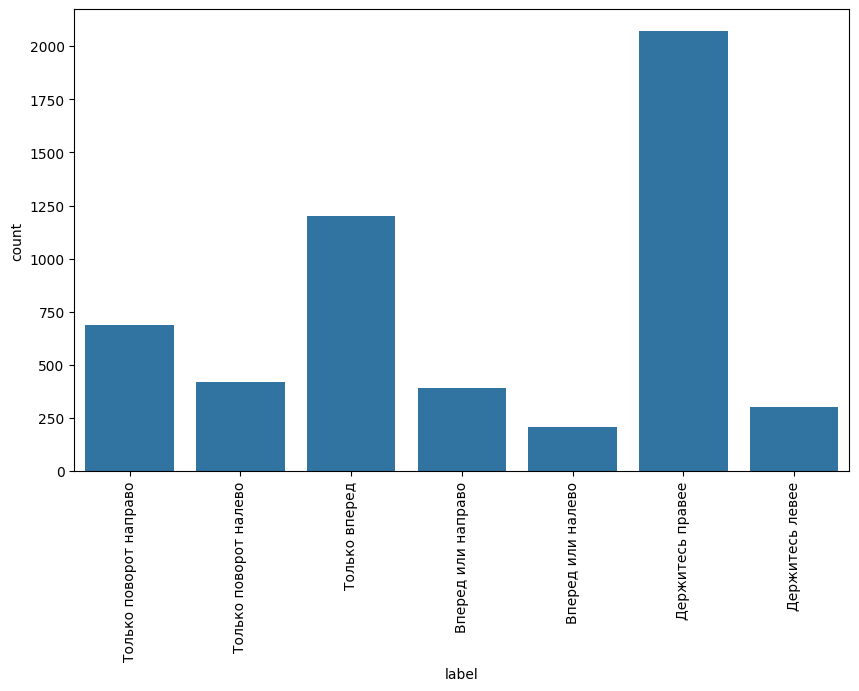

In [6]:
plt.figure(figsize=(10,6))
sns.countplot(x='label', data=data_train)
plt.xticks(rotation=90);

## Создание тестовых и тренировочных выборок

In [7]:
# Зададим параметры изображений
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

def load_images_from_dataframe(df, dir):
    """
    Загружает обрезанные изображения из папки и создает массивы данных и меток

    Параметры:
    df (pd.DataFrame) - DataFrame с колонками ['Path', 'ClassId'].
    dir (str) - Путь к директории с изображениями.

    Возвращает:
    image_data (np.ndarray) - Массив изображений.
    image_labels (np.ndarray) - Массив меток (labelsы).
    """

    image_data = []
    image_labels = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Загрузка изображений"):
        class_id = row['ClassId']
        img_name = os.path.basename(row['Path'])


        ## Этот блок нужен, так как для тренировочных и тестовых данных разные структуры файлов
        ## без него не будет работать на файле /Test (можешь проверить)

        img_path_with_class = os.path.join(dir, str(class_id), img_name)
        img_path_without_class = os.path.join(dir, img_name)

        # Проверяем, какой путь существует
        if os.path.exists(img_path_with_class):
            img_path = img_path_with_class
        elif os.path.exists(img_path_without_class):
            img_path = img_path_without_class
        else:
            print(f"Не удалось найти изображение: {img_name}")
            continue

        ## блок выбора типа файла закончился

        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Не удалось загрузить изображение: {img_path}")
                continue

            image_fromarray = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image) / 255.) # сразу для отрисовки сделем
            image_labels.append(class_id)

        except:
            print(f"Ошибка при обработке {img_path}")

    image_data = np.array(image_data, dtype=np.float32)
    image_labels = np.array(image_labels, dtype=np.int32)

    print(f"Загружено {len(image_data)} изображений.")

    return image_data, image_labels

X_train_crop, y_train_crop = load_images_from_dataframe(data_train, path + '/Train_crop')
X_train, y_train = load_images_from_dataframe(data_train, path + '/Train')

Загрузка изображений: 100%|██████████| 5279/5279 [00:02<00:00, 2067.65it/s]


Загружено 5279 изображений.


Загрузка изображений: 100%|██████████| 5279/5279 [00:02<00:00, 1962.26it/s]

Загружено 5279 изображений.


In [8]:
print(X_train.shape, y_train.shape)

(5279, 30, 30, 3) (5279,)


In [9]:
X_test_crop, y_test_crop = load_images_from_dataframe(data_test, path + '/Test_crop')
X_test, y_test = load_images_from_dataframe(data_test, path + '/Test')

Загрузка изображений: 100%|██████████| 1680/1680 [00:00<00:00, 2167.54it/s]


Загружено 1680 изображений.


Загрузка изображений: 100%|██████████| 1680/1680 [00:00<00:00, 1896.21it/s]

Загружено 1680 изображений.


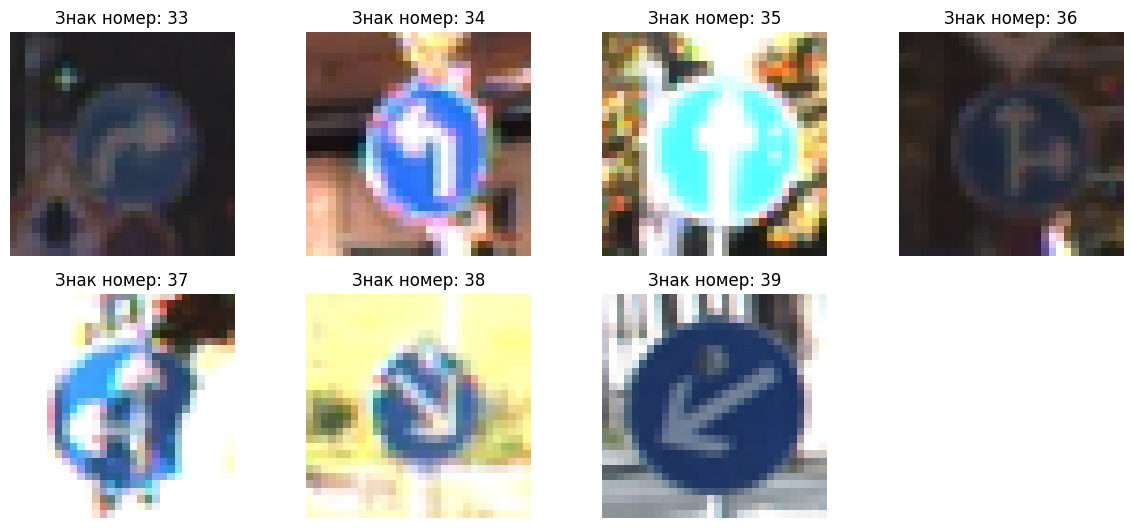

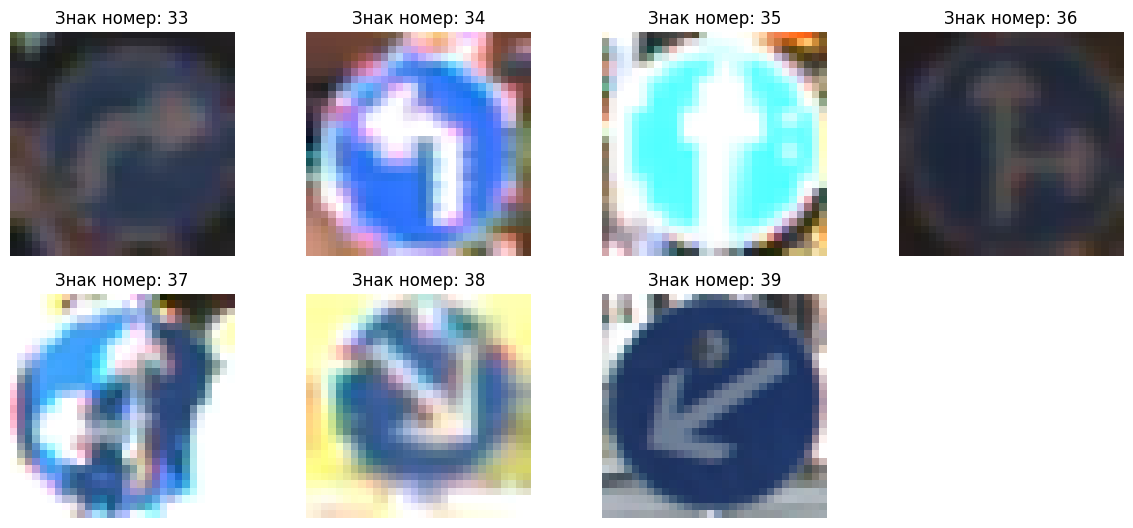

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_unique_images(images, labels, num_classes=42):
    """
    Функция для отображения первых изображений, по одному от каждого уникального класса.

    Параметры:
    - images (np.ndarray) - Набор изображений (X_train)
    - labels (np.ndarray) - Метки изображений (y_train)
    - num_classes (int) - Максимальное количество классов для отображения

    Возвращает:
    None, но зато рисует
    """
    unique_classes = np.unique(labels)
    num_classes = min(num_classes, len(unique_classes))

    # Собираем индексы первых вхождений для каждого уникального класса
    chosen_indices = []
    for class_id in unique_classes[:num_classes]:
        indices = np.where(labels == class_id)[0]
        chosen_indices.append(indices[0])  # Выбираем первый индекс для каждого класса

    # Создаем фигуру и оси
    plt.figure(figsize=(12, 8))

    for i, idx in enumerate(chosen_indices):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[idx])
        plt.axis('off')
        plt.title(f"Знак номер: {labels[idx]}")

    plt.tight_layout()
    plt.show()

plot_unique_images(X_train, y_train)
plot_unique_images(X_train_crop, y_train_crop)

## Обучение

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [12]:
def model_precision(model, Xt, yt):
    y_pred = model.predict(Xt)
    acc = accuracy_score(yt, y_pred)
    f1 = f1_score(yt, y_pred, average='weighted')
    print(f"accuracy = {acc}")
    print(f"f1 score = {f1}")

### SVC (для полных)

In [13]:
X = X_train.reshape(X_train.shape[0], -1)
Xt = X_test.reshape(X_test.shape[0], -1)
y = y_train
yt = y_test

print(X.shape, y.shape, Xt.shape, yt.shape)

(5279, 2700) (5279,) (1680, 2700) (1680,)


In [ ]:
svc = SVC(kernel='linear', random_state=5)
svc.fit(X, y)

SVC(kernel='linear', random_state=5)

In [ ]:
model_precision(svc, Xt, yt)

accuracy = 0.9339285714285714
f1 score = 0.9328298300715049


### SVC (для обрезанных)

In [14]:
X = X_train_crop.reshape(X_train.shape[0], -1)
Xt = X_test_crop.reshape(X_test.shape[0], -1)
y = y_train
yt = y_test

print(X.shape, y.shape, Xt.shape, yt.shape)

(5279, 2700) (5279,) (1680, 2700) (1680,)


In [ ]:
svc = SVC(kernel='linear', random_state=5)
svc.fit(X, y)

SVC(kernel='linear', random_state=5)

In [ ]:
model_precision(svc, Xt, yt)

accuracy = 0.9583333333333334
f1 score = 0.9568903872538169


In [ ]:
print("test Git commiting")

test Git commiting


## Обучения с наилучшими параметрами сразу (только на обрезанных фотках)

In [15]:
X = X_train_crop.reshape(X_train.shape[0], -1)
Xt = X_test_crop.reshape(X_test.shape[0], -1)
y = y_train
yt = y_test

print(X.shape, y.shape, Xt.shape, yt.shape)

(5279, 2700) (5279,) (1680, 2700) (1680,)


### SVC

In [ ]:
svc = SVC(random_state=5)
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svc = GridSearchCV(svc, param_grid_svc, scoring='f1_weighted', cv=4, verbose=2)
grid_svc.fit(X, y)
print("Лучшие параметры для опорных векторов:", grid_svc.best_params_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.9s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   6.9s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.9s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   5.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  39.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  39.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  37.6s


KeyboardInterrupt: 

In [ ]:
model_precision(grid_svc.best_estimator_, Xt, yt)

### LogReg

In [ ]:
logreg = LogisticRegression(random_state=5, max_iter=100)
param_grid_logreg = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
grid_logreg = GridSearchCV(logreg, param_grid_logreg, scoring='f1_weighted', cv=4, verbose=2)
grid_logreg.fit(X, y)
print("Лучшие параметры для логистической регрессии:", grid_logreg.best_params_)

In [ ]:
model_precision(grid_logreg.best_estimator_, Xt, yt)

### KNN

In [ ]:
# 3. Метод k ближайших соседей
knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': [2, 6, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(knn, param_grid_knn, scoring='f1_weighted', cv=4, verbose=2)
grid_knn.fit(X, y)
print("Лучшие параметры для к ближайших соседей:", grid_knn.best_params_)

In [ ]:
model_precision(grid_knn.best_estimator_, Xt, yt)

### DecisionTree

In [ ]:
tree = DecisionTreeClassifier(random_state=5)
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 10]
}
grid_tree = GridSearchCV(tree, param_grid_tree, scoring='f1_weighted', cv=4, verbose=2)
grid_tree.fit(X, y)
print("Лучшие параметры для дерева принятия решений:", grid_tree.best_params_)

In [ ]:
model_precision(grid_tree.best_estimator_, Xt, yt)

### CNN

In [29]:
!pip install keras==3.4.1
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
model = keras.Sequential()

img_rows, img_cols = 30, 30
num_classes = 7

input_shape = (img_rows, img_cols, 3)
# add first convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

# add second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# add one max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add one dropout layer
model.add(Dropout(0.25))

# add flatten layer
model.add(Flatten())

# add dense layer
model.add(Dense(128, activation='relu'))

# add another dropout layer
model.add(Dropout(0.5))

# add dense layer
model.add(Dense(num_classes, activation='softmax'))

# complile the model and view its architecur
model.compile(loss=keras.losses.categorical_crossentropy,  optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 26, 26, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       1,384,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,404,871 (5.36 MB)

 Trainable params: 1,404,871 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 64
epochs = 15

from keras.utils import to_categorical
y_train_cat = to_categorical(y_train - min(y_train), num_classes) # Subtract min value to make classes zero-based
y_test_cat = to_categorical(y_test - min(y_test), num_classes)

# Update the model fitting and evaluation
model.fit(X_train_crop, y_train_cat, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(X_test_crop, y_test_cat))
accuracy = model.evaluate(X_test_crop, y_test_cat, verbose=0)
print('Test accuracy:', accuracy[1])

Epoch 1/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 214ms/step - accuracy: 0.6023 - loss: 1.4102 - val_accuracy: 0.6304 - val_loss: 1.3372
Epoch 2/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - accuracy: 0.6000 - loss: 1.3817 - val_accuracy: 0.6369 - val_loss: 1.3229
Epoch 3/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.6019 - loss: 1.3853 - val_accuracy: 0.6435 - val_loss: 1.3085
Epoch 4/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 0.6086 - loss: 1.3570 - val_accuracy: 0.6470 - val_loss: 1.2939
Epoch 5/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.5992 - loss: 1.3586 - val_accuracy: 0.6560 - val_loss: 1.2788
Epoch 6/15
22/83 ━━━━━━━━━━━━━━━━━━━━ 14s 238ms/step - accuracy: 0.6143 - loss: 1.3190